## Leverage score vs Random

Evolution of test set accuracy of our method as we move data from training set to test set based on BLS ranking vs. randomly.

This notebook was used to generate Figure 2(a).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from tqdm import tqdm

import pickle
import sys
sys.path.append("..")
sys.path.append("../../..")

from src.models.tsvgp_white import t_SVGP_white
from src.models.tsvgp_cont import t_SVGP_cont, OnlineGP, piv_chol, compute_lev, random_picker
from mnist_utils import load_split_mnist, optimize_online_model_minibatch

from exp_utils import optimize_full_model

## Load trained model

This is used to calculate leverage score and move points.

In [2]:
model_path = "../split_mnist_runs/online_memory/14-37-24/model_online.pkl"

with open(model_path, "rb") as f:
    dict_params = pickle.load(f)
        
    kernel = gpflow.kernels.Matern52()
    likelihood = gpflow.likelihoods.Softmax(10)
    inducing_variable = -2 + np.zeros((300, 784)) + np.random.rand(300 * 784).reshape((-1, 784))
    model = t_SVGP_cont(kernel, likelihood, inducing_variable, num_latent_gps=10)

    model.kernel.lengthscales = dict_params['.kernel.lengthscales']
    model.kernel.variance = dict_params['.kernel.variance']

    # Load Z
    model.inducing_variable.Z = dict_params['.inducing_variable.Z']
    Z = model.inducing_variable.Z.numpy().copy()

    # Load variational parameters
    model.lambda_1.assign(dict_params['.sites.lambda_1'])
    model.lambda_2.assign(dict_params['.sites._lambda_2'])

    print("Model loaded successfully!!!")

Model loaded successfully!!!


In [3]:
def set_seet_and_load_mnist(seed=33):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    train_tasks, test_tasks = load_split_mnist(seed=seed)

    all_train_tasks = train_tasks[0]
    all_test_tasks = test_tasks[0]

    for i in range(1, 5):
        all_train_tasks = (np.concatenate([all_train_tasks[0], train_tasks[i][0]], axis=0),
                           np.concatenate([all_train_tasks[1], train_tasks[i][1]], axis=0)
                          )

        all_test_tasks = (np.concatenate([all_test_tasks[0], test_tasks[i][0]], axis=0),
                          np.concatenate([all_test_tasks[1], test_tasks[i][1]], axis=0)
                          )
    
    return all_train_tasks, all_test_tasks


In [4]:
def train(model, train_data, iterations=100, n_e_steps=1, n_m_steps=1, nat_lr=0.1, mb_size=200):
    """
    Utility function for training SVGP models with natural gradients

    :param model: GPflow model
    :param iterations: number of iterations
    """

    print("Optimizing model: ", model.name)
    
    train_dataset = tf.data.Dataset.from_tensor_slices(train_data).repeat()
    
    train_iter = iter(train_dataset.batch(mb_size))
    train_iter2 = iter(train_dataset.batch(mb_size))

    training_loss = model.training_loss_closure(train_iter, compile=True)
    training_loss2 = model.training_loss_closure(train_iter2, compile=True)

    # Define the M-step (that is called in the same way for both)
    optimizer = tf.optimizers.Adam(0.02)

    @tf.function
    def optimization_m_step(training_loss, params):
        optimizer.minimize(training_loss, var_list=params)

    @tf.function
    def optimization_e_step(model, data):
        model.natgrad_step(data, lr=nat_lr)

    for _ in tqdm(range(iterations)):
        data = next(train_iter)

        for i in range(n_e_steps):
            optimization_e_step(model, data)
        for i in range(n_m_steps):
            optimization_m_step(training_loss2, model.trainable_variables)

In [5]:
def get_acc(shift_percentage=0.1, use_lev_score = True):
    N = int(all_train_tasks[0].shape[0] * shift_percentage)
    
    if use_lev_score:
        lev_score, _ = compute_lev(model, all_train_tasks[0], all_train_tasks[1])
        lev_score_idx = np.argsort(lev_score)
        train_idx = list(lev_score_idx[-N:])
    else:
        train_idx = np.random.randint(0, all_train_tasks[0].shape[0], N)
    
    minimized_train_data = (np.delete(all_train_tasks[0], train_idx, axis=0), 
                            np.delete(all_train_tasks[1], train_idx, axis=0))

    minimized_test_data = (np.concatenate([all_test_tasks[0], all_train_tasks[0][train_idx]], axis=0), 
                           np.concatenate([all_test_tasks[1], all_train_tasks[1][train_idx]], axis=0)
                          )
    
    print(f"Leverage score : {use_lev_score}")
    print(f"Shift Percentage: {shift_percentage}")
    print(f"Test size: {minimized_test_data[0].shape}")
    print(f"Train size: {minimized_train_data[0].shape}")
    
    # Shuffle train data
    minimized_train_data = np.concatenate([minimized_train_data[0], minimized_train_data[1]], axis=1)
    np.random.shuffle(minimized_train_data)
    minimized_train_data = (minimized_train_data[:, :-1], minimized_train_data[:, -1:].astype(np.int64))
    
    Z = minimized_train_data[0][:100].copy()
    mem = (minimized_train_data[0][:1], minimized_train_data[0][:1])

    # Leverage
    m_cont = t_SVGP_white(
        likelihood=gpflow.likelihoods.Softmax(10),
        kernel = gpflow.kernels.Matern52(lengthscales=model.kernel.lengthscales.numpy().copy(), 
                                         variance=model.kernel.variance.numpy().copy()),
        inducing_variable=model.inducing_variable.Z.numpy().copy(),
        num_latent_gps=10,
        num_data=minimized_train_data[0].shape[0]
    )

    gpflow.utilities.set_trainable(m_cont.inducing_variable.Z, False)
    gpflow.utilities.set_trainable(m_cont.kernel.lengthscales, False)
    gpflow.utilities.set_trainable(m_cont.kernel.variance, False)

    train(m_cont, minimized_train_data, n_e_steps=10, n_m_steps=0)
    
    pred = m_cont.predict_y(minimized_test_data[0])[0]
    pred_argmax = tf.reshape(tf.argmax(pred, axis=1), (-1, 1))
    acc = np.mean(pred_argmax == minimized_test_data[1])
    
    print(f"Accuracy : {acc}")
    
    return acc

In [6]:
seed = [33, 98, 100, 135, 719]
shift_percentage = [0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.12, 0.15]

all_acc_leverage = []
all_acc_random = []

for s in seed:
    acc_leverage = []
    acc_random = []
    all_train_tasks, all_test_tasks = set_seet_and_load_mnist(s)
    
    for per in shift_percentage:
        acc_leverage.append(get_acc(per, True))   
        acc_random.append(get_acc(per, False))
    
    all_acc_random += acc_random
    all_acc_leverage += acc_leverage


Leverage score : True
Shift Percentage: 0.01
Test size: (14561, 784)
Train size: (55439, 784)


2023-06-10 13:07:08.611083: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Optimizing model:  t_svgp_white


  0%|                                                                                                                                                                                       | 0/100 [00:00<?, ?it/s]2023-06-10 13:07:10.322724: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-06-10 13:07:10.324072: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]


Accuracy : 0.8524139825561431
Leverage score : False
Shift Percentage: 0.01
Test size: (14561, 784)
Train size: (55441, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.64it/s]


Accuracy : 0.8794725636975482
Leverage score : True
Shift Percentage: 0.02
Test size: (15121, 784)
Train size: (54879, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.83it/s]


Accuracy : 0.8211097149659414
Leverage score : False
Shift Percentage: 0.02
Test size: (15121, 784)
Train size: (54893, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


Accuracy : 0.8775874611467496
Leverage score : True
Shift Percentage: 0.03
Test size: (15681, 784)
Train size: (54319, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.80it/s]


Accuracy : 0.8245647599005166
Leverage score : False
Shift Percentage: 0.03
Test size: (15681, 784)
Train size: (54348, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.53it/s]


Accuracy : 0.8763471717364963
Leverage score : True
Shift Percentage: 0.05
Test size: (16801, 784)
Train size: (53199, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.47it/s]


Accuracy : 0.8050711267186477
Leverage score : False
Shift Percentage: 0.05
Test size: (16801, 784)
Train size: (53257, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.50it/s]


Accuracy : 0.8749479197666805
Leverage score : True
Shift Percentage: 0.07
Test size: (17921, 784)
Train size: (52079, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.60it/s]


Accuracy : 0.779030188047542
Leverage score : False
Shift Percentage: 0.07
Test size: (17921, 784)
Train size: (52206, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.61it/s]


Accuracy : 0.8766251883265442
Leverage score : True
Shift Percentage: 0.1
Test size: (19601, 784)
Train size: (50399, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.67it/s]


Accuracy : 0.7475638998010306
Leverage score : False
Shift Percentage: 0.1
Test size: (19601, 784)
Train size: (50654, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.67it/s]


Accuracy : 0.8768940360185705
Leverage score : True
Shift Percentage: 0.12
Test size: (20721, 784)
Train size: (49279, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.61it/s]


Accuracy : 0.7489020800154432
Leverage score : False
Shift Percentage: 0.12
Test size: (20721, 784)
Train size: (49641, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54it/s]


Accuracy : 0.8795907533420202
Leverage score : True
Shift Percentage: 0.15
Test size: (22401, 784)
Train size: (47599, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]


Accuracy : 0.7323780188384447
Leverage score : False
Shift Percentage: 0.15
Test size: (22401, 784)
Train size: (48199, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]


Accuracy : 0.8773715459131288
Leverage score : True
Shift Percentage: 0.01
Test size: (14561, 784)
Train size: (55439, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


Accuracy : 0.8524139825561431
Leverage score : False
Shift Percentage: 0.01
Test size: (14561, 784)
Train size: (55441, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.53it/s]


Accuracy : 0.8677288647757709
Leverage score : True
Shift Percentage: 0.02
Test size: (15121, 784)
Train size: (54879, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


Accuracy : 0.8357912836452616
Leverage score : False
Shift Percentage: 0.02
Test size: (15121, 784)
Train size: (54889, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.76it/s]


Accuracy : 0.8654189537728986
Leverage score : True
Shift Percentage: 0.03
Test size: (15681, 784)
Train size: (54319, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.76it/s]


Accuracy : 0.8218225878451629
Leverage score : False
Shift Percentage: 0.03
Test size: (15681, 784)
Train size: (54341, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.60it/s]


Accuracy : 0.872202027931892
Leverage score : True
Shift Percentage: 0.05
Test size: (16801, 784)
Train size: (53199, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.73it/s]


Accuracy : 0.7965002083209333
Leverage score : False
Shift Percentage: 0.05
Test size: (16801, 784)
Train size: (53259, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.80it/s]


Accuracy : 0.8725671091006487
Leverage score : True
Shift Percentage: 0.07
Test size: (17921, 784)
Train size: (52079, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.79it/s]


Accuracy : 0.7695999107192679
Leverage score : False
Shift Percentage: 0.07
Test size: (17921, 784)
Train size: (52215, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.68it/s]


Accuracy : 0.8654092963562301
Leverage score : True
Shift Percentage: 0.1
Test size: (19601, 784)
Train size: (50399, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.82it/s]


Accuracy : 0.7436355287995511
Leverage score : False
Shift Percentage: 0.1
Test size: (19601, 784)
Train size: (50658, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.50it/s]


Accuracy : 0.8769960716289985
Leverage score : True
Shift Percentage: 0.12
Test size: (20721, 784)
Train size: (49279, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]


Accuracy : 0.744220838762608
Leverage score : False
Shift Percentage: 0.12
Test size: (20721, 784)
Train size: (49721, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.82it/s]


Accuracy : 0.8721586796004054
Leverage score : True
Shift Percentage: 0.15
Test size: (22401, 784)
Train size: (47599, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


Accuracy : 0.7099683049863845
Leverage score : False
Shift Percentage: 0.15
Test size: (22401, 784)
Train size: (48203, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.58it/s]


Accuracy : 0.8675059149145128
Leverage score : True
Shift Percentage: 0.01
Test size: (14561, 784)
Train size: (55439, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.80it/s]


Accuracy : 0.8514525101297987
Leverage score : False
Shift Percentage: 0.01
Test size: (14561, 784)
Train size: (55440, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.65it/s]


Accuracy : 0.8770688826316874
Leverage score : True
Shift Percentage: 0.02
Test size: (15121, 784)
Train size: (54879, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


Accuracy : 0.8316910257258118
Leverage score : False
Shift Percentage: 0.02
Test size: (15121, 784)
Train size: (54887, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.73it/s]


Accuracy : 0.8742808015342901
Leverage score : True
Shift Percentage: 0.03
Test size: (15681, 784)
Train size: (54319, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.76it/s]


Accuracy : 0.8111727568394873
Leverage score : False
Shift Percentage: 0.03
Test size: (15681, 784)
Train size: (54349, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.60it/s]


Accuracy : 0.879344429564441
Leverage score : True
Shift Percentage: 0.05
Test size: (16801, 784)
Train size: (53199, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.82it/s]


Accuracy : 0.8047140051187429
Leverage score : False
Shift Percentage: 0.05
Test size: (16801, 784)
Train size: (53268, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


Accuracy : 0.8756026426998393
Leverage score : True
Shift Percentage: 0.07
Test size: (17921, 784)
Train size: (52079, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.70it/s]


Accuracy : 0.771385525361308
Leverage score : False
Shift Percentage: 0.07
Test size: (17921, 784)
Train size: (52195, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


Accuracy : 0.8738909659059204
Leverage score : True
Shift Percentage: 0.1
Test size: (19601, 784)
Train size: (50399, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]


Accuracy : 0.7415437987857763
Leverage score : False
Shift Percentage: 0.1
Test size: (19601, 784)
Train size: (50675, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.70it/s]


Accuracy : 0.8785266057854191
Leverage score : True
Shift Percentage: 0.12
Test size: (20721, 784)
Train size: (49279, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.70it/s]


Accuracy : 0.7379470102794267
Leverage score : False
Shift Percentage: 0.12
Test size: (20721, 784)
Train size: (49663, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.80it/s]


Accuracy : 0.8746682109936779
Leverage score : True
Shift Percentage: 0.15
Test size: (22401, 784)
Train size: (47599, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.73it/s]


Accuracy : 0.7318869693317263
Leverage score : False
Shift Percentage: 0.15
Test size: (22401, 784)
Train size: (48205, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


Accuracy : 0.8767019329494219
Leverage score : True
Shift Percentage: 0.01
Test size: (14561, 784)
Train size: (55439, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.81it/s]


Accuracy : 0.8456149989698509
Leverage score : False
Shift Percentage: 0.01
Test size: (14561, 784)
Train size: (55440, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]


Accuracy : 0.8761760868072248
Leverage score : True
Shift Percentage: 0.02
Test size: (15121, 784)
Train size: (54879, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.78it/s]


Accuracy : 0.8320878248793069
Leverage score : False
Shift Percentage: 0.02
Test size: (15121, 784)
Train size: (54888, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.64it/s]


Accuracy : 0.8799682560677203
Leverage score : True
Shift Percentage: 0.03
Test size: (15681, 784)
Train size: (54319, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


Accuracy : 0.8192717301192526
Leverage score : False
Shift Percentage: 0.03
Test size: (15681, 784)
Train size: (54338, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


Accuracy : 0.8833620304827499
Leverage score : True
Shift Percentage: 0.05
Test size: (16801, 784)
Train size: (53199, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


Accuracy : 0.7866793643235521
Leverage score : False
Shift Percentage: 0.05
Test size: (16801, 784)
Train size: (53263, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


Accuracy : 0.8774477709660139
Leverage score : True
Shift Percentage: 0.07
Test size: (17921, 784)
Train size: (52079, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]


Accuracy : 0.7707717203281067
Leverage score : False
Shift Percentage: 0.07
Test size: (17921, 784)
Train size: (52197, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


Accuracy : 0.8757323810055242
Leverage score : True
Shift Percentage: 0.1
Test size: (19601, 784)
Train size: (50399, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.66it/s]


Accuracy : 0.7394010509667874
Leverage score : False
Shift Percentage: 0.1
Test size: (19601, 784)
Train size: (50668, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.72it/s]


Accuracy : 0.8751594306412938
Leverage score : True
Shift Percentage: 0.12
Test size: (20721, 784)
Train size: (49279, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.87it/s]


Accuracy : 0.7333140292456928
Leverage score : False
Shift Percentage: 0.12
Test size: (20721, 784)
Train size: (49671, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.72it/s]


Accuracy : 0.8759229766903142
Leverage score : True
Shift Percentage: 0.15
Test size: (22401, 784)
Train size: (47599, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.80it/s]


Accuracy : 0.7137181375831436
Leverage score : False
Shift Percentage: 0.15
Test size: (22401, 784)
Train size: (48183, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54it/s]


Accuracy : 0.8615240391053971
Leverage score : True
Shift Percentage: 0.01
Test size: (14561, 784)
Train size: (55439, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]


Accuracy : 0.848224709841357
Leverage score : False
Shift Percentage: 0.01
Test size: (14561, 784)
Train size: (55444, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]


Accuracy : 0.8666300391456631
Leverage score : True
Shift Percentage: 0.02
Test size: (15121, 784)
Train size: (54879, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


Accuracy : 0.830368361880828
Leverage score : False
Shift Percentage: 0.02
Test size: (15121, 784)
Train size: (54888, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


Accuracy : 0.8765293300707625
Leverage score : True
Shift Percentage: 0.03
Test size: (15681, 784)
Train size: (54319, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]


Accuracy : 0.8165933295070468
Leverage score : False
Shift Percentage: 0.03
Test size: (15681, 784)
Train size: (54350, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.58it/s]


Accuracy : 0.8579172246667942
Leverage score : True
Shift Percentage: 0.05
Test size: (16801, 784)
Train size: (53199, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


Accuracy : 0.8023331944527111
Leverage score : False
Shift Percentage: 0.05
Test size: (16801, 784)
Train size: (53258, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.72it/s]


Accuracy : 0.8732218320338075
Leverage score : True
Shift Percentage: 0.07
Test size: (17921, 784)
Train size: (52079, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.79it/s]


Accuracy : 0.7612856425422688
Leverage score : False
Shift Percentage: 0.07
Test size: (17921, 784)
Train size: (52243, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


Accuracy : 0.8795826125774231
Leverage score : True
Shift Percentage: 0.1
Test size: (19601, 784)
Train size: (50399, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.59it/s]


Accuracy : 0.7457272588133258
Leverage score : False
Shift Percentage: 0.1
Test size: (19601, 784)
Train size: (50689, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.53it/s]


Accuracy : 0.8690883118208255
Leverage score : True
Shift Percentage: 0.12
Test size: (20721, 784)
Train size: (49279, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


Accuracy : 0.746054727088461
Leverage score : False
Shift Percentage: 0.12
Test size: (20721, 784)
Train size: (49673, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.58it/s]


Accuracy : 0.8719656387239998
Leverage score : True
Shift Percentage: 0.15
Test size: (22401, 784)
Train size: (47599, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.60it/s]


Accuracy : 0.7317530467389849
Leverage score : False
Shift Percentage: 0.15
Test size: (22401, 784)
Train size: (48190, 784)
Optimizing model:  t_svgp_white


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.69it/s]


Accuracy : 0.8747823757867952


In [7]:
# get the initial point acc
pred = model.predict_y(all_test_tasks[0])[0]
pred_argmax = tf.reshape(tf.argmax(pred, axis=1), (-1, 1))
acc = np.mean(pred_argmax == all_test_tasks[1])

In [8]:
all_acc_leverage = np.array(all_acc_leverage).reshape((len(seed), -1))
all_acc_random = np.array(all_acc_random).reshape((len(seed), -1))

all_acc_leverage = np.concatenate([acc*np.ones((len(seed), 1)), all_acc_leverage], axis=1)
all_acc_random = np.concatenate([acc*np.ones((len(seed), 1)), all_acc_random], axis=1)

shift_percentage = [0] + shift_percentage
shift_percentage = [i * 100 for i in shift_percentage]

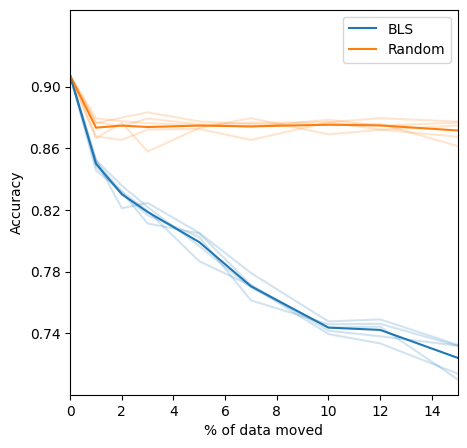

In [12]:
mean_bls = np.mean(all_acc_leverage, axis=0)
mean_random = np.mean(all_acc_random, axis=0)

fig, axs = plt.subplots(1,1,figsize=(5, 5))

plt.plot(shift_percentage, mean_bls, label="BLS", color="tab:blue")
plt.plot(shift_percentage, mean_random, label="Random", color="tab:orange")


for acc_leverage, acc_random in zip(all_acc_leverage, all_acc_random):
    plt.plot(shift_percentage, acc_leverage, color="tab:blue", alpha=0.2)
    plt.plot(shift_percentage, acc_random, color="tab:orange", alpha=0.2)

plt.xlabel("% of data moved")
plt.ylabel("Accuracy")

# plt.xticks([0, 0.05])
plt.yticks([0.90, 0.86, 0.82, 0.78, 0.74])

plt.xlim([-0.0, 15.0])
plt.ylim([0.70, 0.95])

plt.legend()
plt.show()